In [2]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
# from tsne_python.tsne import tsne

In [15]:
power_spec = torch.Tensor(np.load("CB_power_100data_60bp_25fBin.npy"))
(num_bp, num_coord, num_freq, num_frame) = power_spec.shape
pwr = torch.reshape(power_spec, (num_bp*num_coord*num_freq, num_frame)).t()
amp = pwr.sum(dim=1)
pwr = (pwr.t()/amp).t().numpy()

In [79]:
trainingSetSize = 50
perplexity = 32
sigmaTolerance = 1e-4
maxNeighbors = 10

def KL_Divergence(data):
    (N, D) = data.shape
    log_data = torch.log(data)
    # CHECK FOR INF AND NAN
    inf_idx = np.isinf(log_data)
    nan_idx = np.isnan(log_data)
    log_data[inf_idx] = 0
    log_data[nan_idx] = 0
    # COMPUTE ENTROPY
    entropy = (data*log_data).sum(dim=0)
    
    D = -1.0*log_data.t()@data
    D = (D.t() - entropy).t()/np.log(2)
    D = D - torch.diag(torch.diag(D))
    return D

# KL Divergence
(num_bp, num_coord, num_freq, num_frame) = power_spec.shape
pwr = torch.reshape(power_spec, (num_bp*num_coord*num_freq, num_frame))
amp = pwr.sum(dim=0)
pwr = pwr/amp
interval = round(num_frame/trainingSetSize)
train_pwr = pwr[0::interval]
train_amp = amp[0::interval]
D = KL_Divergence(pwr)
# tSNE
D = (D/torch.max(D)).pow(2)

In [4]:
X = np.loadtxt("tsne_python/mnist2500_X.txt")
X.shape
# Y = tsne(X=X, no_dims=2, initial_dims=50, perplexity=20.0)

(2500, 784)

In [21]:
Y_pwr = tsne(X=pwr, no_dims=2, initial_dims=50, perplexity=20.0, max_iter=1000)
plt.scatter(Y_pwr[:,0], Y_pwr[:,1])
plt.show()

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 100...
Mean value of sigma: 0.002319
Iteration 10: error is 13.015214
Iteration 20: error is 11.561271
Iteration 30: error is 11.912154
Iteration 40: error is 11.821478
Iteration 50: error is 11.521408
Iteration 60: error is 11.444386
Iteration 70: error is 11.951198
Iteration 80: error is 11.827529
Iteration 90: error is 11.907067
Iteration 100: error is 12.245178
Iteration 110: error is 1.644884
Iteration 120: error is 1.332422
Iteration 130: error is 1.059904
Iteration 140: error is 0.911998
Iteration 150: error is 0.780692
Iteration 160: error is 0.698864
Iteration 170: error is 0.594606
Iteration 180: error is 0.533901
Iteration 190: error is 0.507500
Iteration 200: error is 0.475287
Iteration 210: error is 0.425850
Iteration 220: error is 0.431891
Iteration 230: error is 0.398115
Iteration 240: error is 0.388121
Iteration 250: error is 0.372229
Iteration 260: error is 0.366724
It

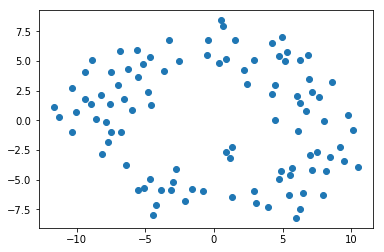

In [19]:
#
#  tsne.py
#
# Implementation of t-SNE in Python. The implementation was tested on Python
# 2.7.10, and it requires a working installation of NumPy. The implementation
# comes with an example on the MNIST dataset. In order to plot the
# results of this example, a working installation of matplotlib is required.
#
# The example can be run by executing: `ipython tsne.py`
#
#
#  Created by Laurens van der Maaten on 20-12-08.
#  Copyright (c) 2008 Tilburg University. All rights reserved.

import numpy as np
import pylab


def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0, max_iter=1000):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y


# if __name__ == "__main__":
#     print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
#     print("Running example on 2,500 MNIST digits...")
#     X = np.loadtxt("mnist2500_X.txt")
#     labels = np.loadtxt("mnist2500_labels.txt")
#     Y = tsne(X, 2, 50, 20.0)
#     pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
#     pylab.show()
